<h1>Sentiment Analysis of a Hate Speech Detection Dataset</h1>

Jared Neumann
<br>
Olga Scrivner
<br>
DSCI D590
<br>
30 April 2021

In this notebook, sentiment analysis is performed on a hate speech dataset from [Waseem 2016](#References). In addition, two hypotheses are explored: (1) that additional information concerning the presence of hate speech aids in the sentiment analysis, and (2) that additional information concerning sentiment aids in the detection of hate speech.

Rather than separate analysis and evaluation under distinct headings, four distinct evaluations are provided for each of the three models (Support Vector Classifier, Logistic Regression, and Naive Bayes): (1) the baseline performance for sentiment prediction, (2) the performance for sentiment prediction with additional hate speech information, (3) the baseline performance for hate speech prediction, and (4) the performance for hate speech prediction with additional sentiment information.

To aid in grading, a Table of Contents is provided with sections for grading labeled with a &diams; symbol. Furthermore, each section heading is accompanied with a &#8593; symbol linked back to the Table of Contents for ease of navigation. Notes: vectorization is performed in multiple places, so does not have a distinct section; also, accuracy scores are given in each evaluation report, but also summarized in the conclusion.

<a id='TOC'></a>
## Table of Contents
* [Data Description](#Description) &diams;
* [Data Processing](#Processing) &diams;
* [Sentiment Labels](#Labels) &diams;
    * [Constructing the Datasets](#Datasets) &diams;
    * [Training Label Distributions](#Training-Distribution) &diams;
* [Topic Analysis](#Topics) &diams;
* [Analysis & Evaluation Pipelines](#Pipelines) &diams;
    * [Support Vector Classifier](#SVC) &diams;
        * [Baseline Performance for Sentiment Prediction](#S-Baseline-SVM) &diams;
        * [Performance with Additional Hate Speech Information](#S+HS-SVM)
        * [Baseline Performance for Hate Speech Prediction](#HS-Baseline-SVM)
        * [Performance with Additional Sentiment Information](#HS+S-SVM)
    * [Logistic Regression](#LR) &diams;
        * [Baseline Performance for Sentiment Prediction](#S-Baseline-LR) &diams;
        * [Performance with Additional Hate Speech Information](#S+HS-LR)
        * [Baseline Performance for Hate Speech Prediction](#HS-Baseline-LR)
        * [Performance with Additional Sentiment Information](#HS+S-LR)
    * [Naive Bayes](#NB) &diams;
        * [Baseline Performance for Sentiment Prediction](#S-Baseline-NB) &diams;
        * [Performance with Additional Hate Speech Information](#S+HS-NB)
        * [Baseline Performance for Hate Speech Prediction](#HS-Baseline-NB)
        * [Performance with Additional Sentiment Information](#HS+S-NB)
* [Conclusion](#Conclusion) &diams;
* [References](#References) &diams;

<a id='Description'></a>
## Data Description [&#8593;](#TOC)

The included dataset was created by Zeerak Waseem and Dirk Hovy for hate speech detection (<a href=https://www.aclweb.org/anthology/N16-2013.pdf>Waseem and Hovy, 2016</a>). The data is comprised of Tweets labeled according to a binary classification schema (i.e., 1: contains hate speech; 2: contains no hate speech). The training set includes 14143 Tweets and the testing set includes 1572 Tweets, each contianing ~31% Tweets labeled with hate speech. However, since the data is not labeled for sentiment, the vader library is used for unsupervised labeling. 

<a id='Processing'></a>
## Data Processing [&#8593;](#TOC)

To process the data, the training and testing sets (already separated) need to be converted into lists. As most tokens might be relevant for hate speech, only URLs and newlines are removed. However, the pipeline for each classifier will also convert tokens to lowercase by default. That feature is retained. For the wordclouds, the NLTK stopwords list is extended and used for display purposes. Other preprocessing steps are suggested in the [Conclusion](#Conclusion).

In [2]:
import preprocessor as p

# Only eliminate URLs with the preprocessor.
p.set_options(p.OPT.URL)

# Define the preprocessing functions.
def preprocess(data):
    cleaned_data = []
    for line in data:
        cleaned_data.append(p.clean(line))
    return cleaned_data

def get_data(path):
    with open(path, encoding = 'utf-8') as f:
        data = list(f)
    return preprocess(data)

In [3]:
# Preprocess each data file.
train_X = get_data('data/waseemtrain.txt')
test_X = get_data('data/waseemtest.txt')
train_y = get_data('data/waseemtrainGold.txt')
test_y = get_data('data/waseemtestGold.txt')

<a id='Labels'></a>
## Sentiment Labels [&#8593;](#TOC)

Since the dataset does not already include sentiment labels, they are supplied here using vader.

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Get Binary Sentiment Labels for Training Data.
sentiments_train = []
for tweet in train_X:
    scores_train = analyzer.polarity_scores(tweet)
    if scores_train['pos'] >= scores_train['neg']:
        sentiments_train.append('+pos')
    else:
        sentiments_train.append('-neg')

# Get Binary Sentiment Labels for Testing Data.
sentiments_test = []
for tweet in test_X:
    scores_test = analyzer.polarity_scores(tweet)
    if scores_test['pos'] >= scores_test['neg']:
        sentiments_test.append('+pos')
    else:
        sentiments_test.append('-neg')

<a id='Datasets'></a>
### Constructing the Datasets [&#8593;](#TOC)

The lists obtained above are treated as unique columns in a single Pandas DataFrame for ease of reference.

In [6]:
import pandas as pd

# Combine all training lists into a DataFrame.
df_train_dict = {"Tweets": train_X, "HS_Labels": train_y, "S_Labels": sentiments_train}
df_train = pd.DataFrame(df_train_dict)
df_train['HS_Labels'] = df_train['HS_Labels'].replace({'1': '+hs', '2': '-hs'})

# Do the same for the testing lists.
df_test_dict = {"Tweets": test_X, "HS_Labels": test_y, "S_Labels": sentiments_test}
df_test = pd.DataFrame(df_test_dict)
df_test['HS_Labels'] = df_test['HS_Labels'].replace({'1': '+hs', '2': '-hs'})

<a id='Training-Distribution'></a>
### Training Label Distribution [&#8593;](#TOC)

The sentiment labels are distributed as follows:

In [7]:
sentiment_counts = df_train.S_Labels.value_counts()
sentiment_counts

+pos    8404
-neg    5739
Name: S_Labels, dtype: int64

<AxesSubplot:title={'center':'Sentiment Analysis'}>

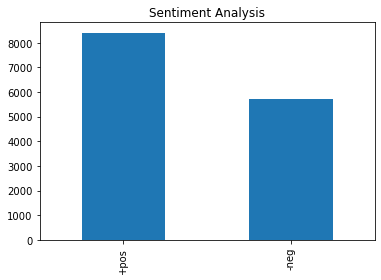

In [9]:
sentiment_counts.plot(kind='bar',title="Sentiment Analysis")

<a id='Topics'></a>
## Topic Analysis [&#8593;](#TOC)

Topic analysis is performed using Sklearn's Latent Dirichlet Allocation module. All Tweets with positive labels and negative labels are separated for analysis, respectively, to get an idea of the kind of topics associated with each label.

In [10]:
#Import Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [12]:
positive = df_train.loc[df_train['S_Labels'] == '+pos']
negative = df_train.loc[df_train['S_Labels'] == '-neg']

The following code to obtain the topics of the Tweets in the training set using Latent Dirchlet Allocation is adapted from <a href=https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730>Bakharia 2016</a> and <a href=https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn>Mehrotra 2019</a>. See [References](#References).

In [69]:
# Initialize CountVectorizer for positive sentiment Tweets
tf_vectorizer_positive = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf_positive = tf_vectorizer_positive.fit_transform(positive['Tweets'].tolist())
tf_feature_names_positive = tf_vectorizer_positive.get_feature_names()

# Run LDA on the positive sentiment Tweets.
lda_model_positive = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online',random_state=0)
lda_topics_positive = lda_model_positive.fit_transform(tf_positive)

In [70]:
# Initialize CountVectorizer for positive sentiment Tweets, removing stopwords.
tf_vectorizer_negative = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf_negative = tf_vectorizer_negative.fit_transform(negative['Tweets'].tolist())
tf_feature_names_negative = tf_vectorizer_negative.get_feature_names()

# Run LDA on the positive sentiment Tweets.
lda_model_negative = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online',random_state=0)
lda_topics_negative = lda_model_negative.fit_transform(tf_negative)

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Use NLTK stopwords extended with a couple of Twitter tokens.
stop_words = set(stopwords.words('english'))
stop_words.add('rt')
stop_words.add('http')
stop_words.add('https')

vocabulary_positive = tf_vectorizer_positive.get_feature_names()
vocabulary_negative = tf_vectorizer_negative.get_feature_names()

# Generate a word cloud image for given topic
def draw_wordcloud(model, vocab, index):
    
    m = model
    v = vocab
    i = index
    
    topic_words = ""
    topic_components = m.components_[i]
    vocabulary_components = zip(v, topic_components)
    sorted_words = sorted(vocabulary_components, key=lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        topic_words = topic_words + " " + word[0]

    wordcloud = WordCloud(stopwords=stop_words, width=600, height=400).generate(topic_words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

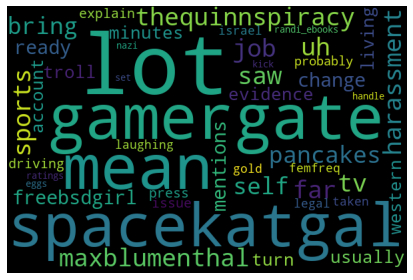

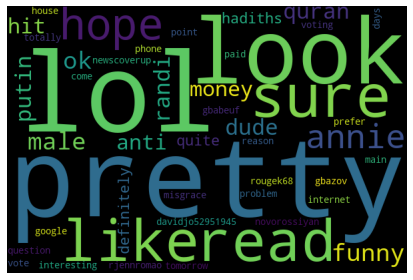

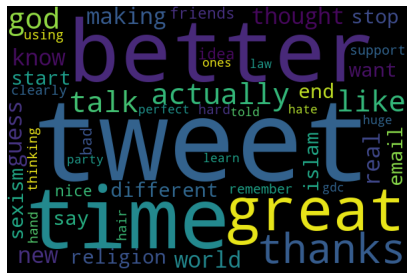

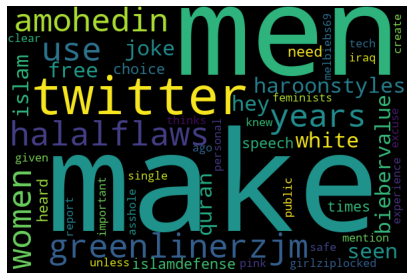

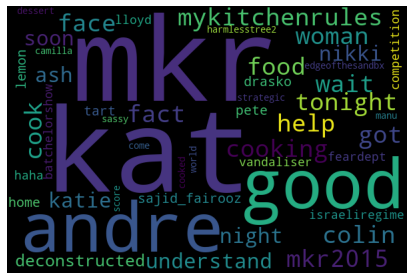

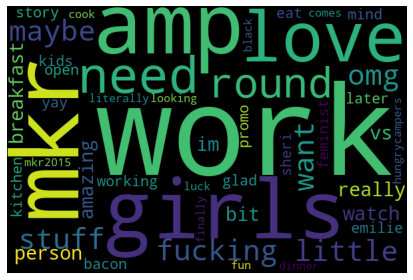

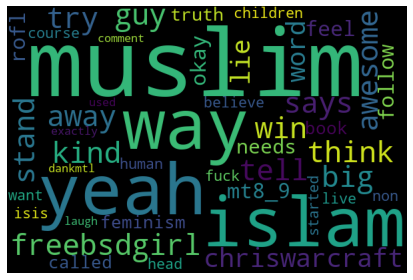

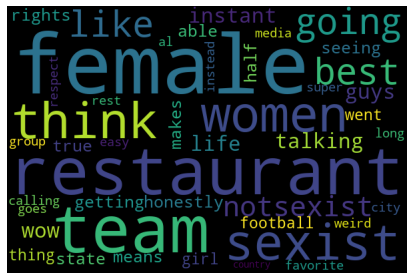

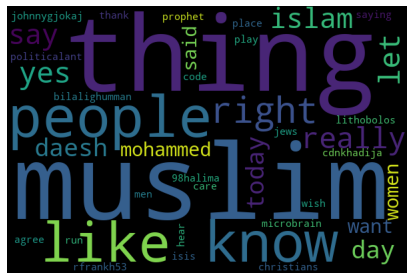

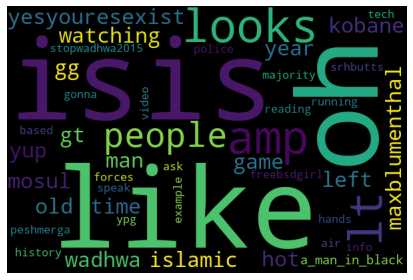

In [72]:
# Wordcloud for topics in positive Tweets
for i in range(0,10):
    draw_wordcloud(lda_model_positive, vocabulary_positive, i)

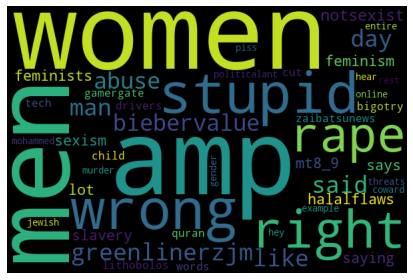

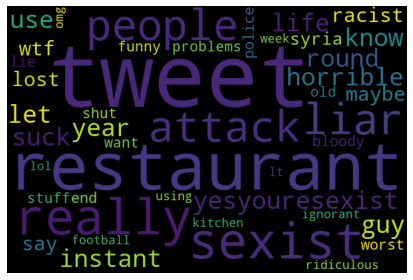

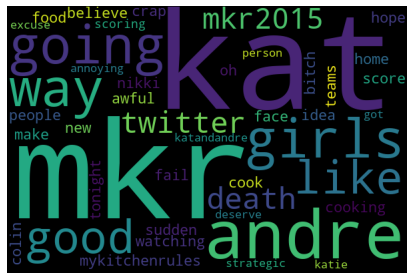

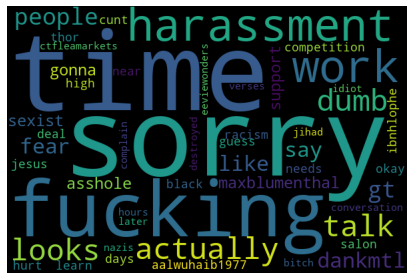

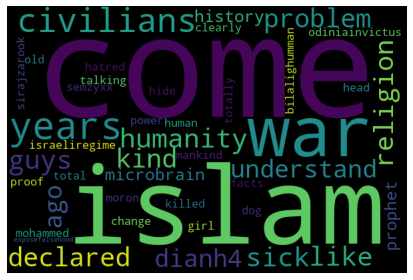

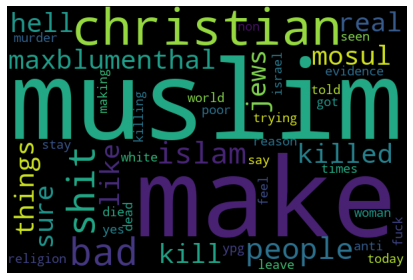

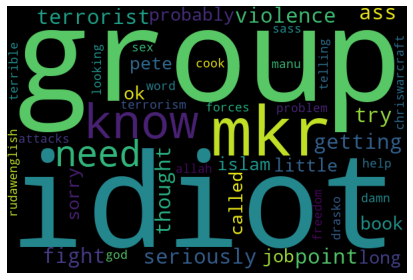

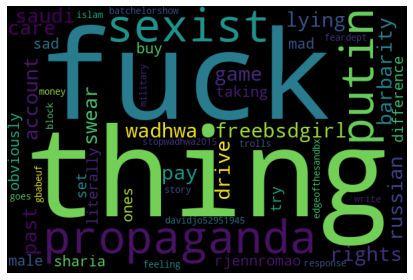

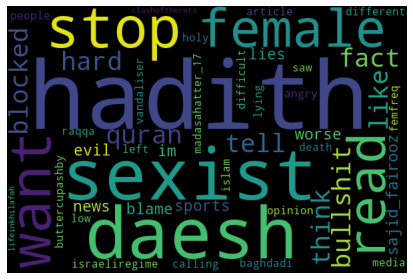

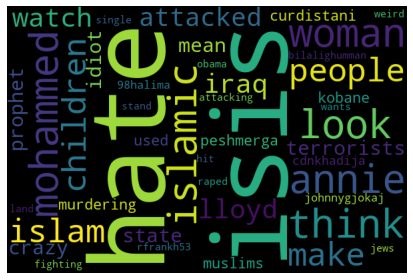

In [73]:
# Wordcloud for topics in negative Tweets
for i in range(0,10):
    draw_wordcloud(lda_model_negative, vocabulary_negative, i)

<a id='Pipelines'></a>
## Analysis & Evaluation Pipelines [&#8593;](#TOC)

Three distinct pipelines are defined, one for each classifier (Support Vector, Logistic Regression, and Naive Bayes) so that optimization and evaluation can be performed on a case-by-case basis. Four evaluation reports are generated for each.

In [195]:
#Import Models
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Import Infrastructure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Import Reports
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

<a id='SVC'></a>
### Support Vector Classifier [&#8593;](#TOC)

In [173]:
def SVM(train_X, train_y, test_X, test_y):

    #Define the support vector machine (SVM) pipeline.
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', svm.SVC(gamma='scale'))
    ])

    #Define the optional parameters to be tried with SVM.
    params = {
        'vect__ngram_range':[(2,2),(2,3)],
        'clf__C':(1, 2),
        'clf__kernel': ('sigmoid','rbf'),
        'clf__shrinking':(True, False),
        'tfidf__use_idf':(True, False)
    }

    #Try optional parameters with GridSearchCV
    gs_clf = GridSearchCV(text_clf, params, cv=5, n_jobs=-1)
    gs_clf.fit(train_X, train_y)
    preds = gs_clf.predict(test_X)

    #Get the best parameters.
    best_params = gs_clf.best_params_
    print()
    print("+----------------------------------------------------+")
    print(" Best parameters:")
    print("+----------------------------------------------------+")
    for key in best_params.keys():
        print(key + ': ' + str(best_params[key]))
    print()

    #Get the classification report.
    report = classification_report(test_y, preds, digits=6)
    print("+----------------------------------------------------+")
    print(" Classification report:")
    print("+----------------------------------------------------+")
    print(report)
    
    #Get the confusion matrix.
    cm = confusion_matrix(test_y, preds, labels=gs_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_clf.classes_)
    print("+----------------------------------------------------+")
    print(" Confusion Matrix:")
    print("+----------------------------------------------------+")
    disp.plot()

<a id='S-Baseline-SVM'></a>
#### Baseline Performance for Sentiment Prediction [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 1
clf__kernel: sigmoid
clf__shrinking: True
tfidf__use_idf: True
vect__ngram_range: (2, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

        +pos   0.718525  0.854545  0.780655       935
        -neg   0.704348  0.508634  0.590702       637

    accuracy                       0.714377      1572
   macro avg   0.711437  0.681590  0.685678      1572
weighted avg   0.712780  0.714377  0.703683      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


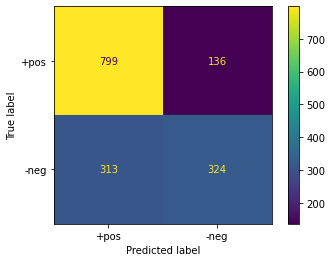

In [260]:
SVM(df_train['Tweets'].tolist(), 
   df_train['S_Labels'].tolist(), 
   df_test['Tweets'].tolist(), 
   df_test['S_Labels'].tolist())

<a id='S+HS-SVM'></a>
#### Performance with Additional Hate Speech Information [&#8593;](#TOC)

In [279]:
df_train['Tweets_HS'] = df_train[['Tweets', 'HS_Labels']].agg(' '.join, axis=1)
df_test['Tweets_HS'] = df_test[['Tweets', 'HS_Labels']].agg(' '.join, axis=1)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 1
clf__kernel: sigmoid
clf__shrinking: False
tfidf__use_idf: True
vect__ngram_range: (2, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

        +pos   0.730347  0.854545  0.787580       935
        -neg   0.715481  0.536892  0.613453       637

    accuracy                       0.725827      1572
   macro avg   0.722914  0.695719  0.700517      1572
weighted avg   0.724323  0.725827  0.717021      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


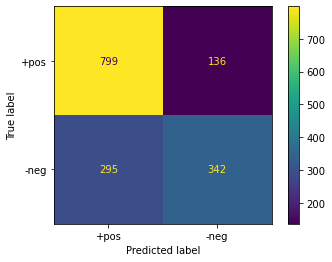

In [263]:
SVM(df_train['Tweets_HS'].tolist(), 
   df_train['S_Labels'].tolist(), 
   df_test['Tweets_HS'].tolist(), 
   df_test['S_Labels'].tolist())

<a id='HS-Baseline-SVM'></a>
#### Baseline Performance for Hate Speech Predictions [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 1
clf__kernel: rbf
clf__shrinking: True
tfidf__use_idf: False
vect__ngram_range: (2, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

         +hs   0.840708  0.383065  0.526316       496
         -hs   0.772660  0.966543  0.858794      1076

    accuracy                       0.782443      1572
   macro avg   0.806684  0.674804  0.692555      1572
weighted avg   0.794130  0.782443  0.753890      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


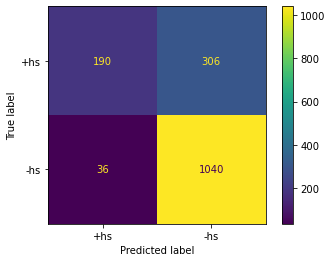

In [177]:
SVM(df_train['Tweets'].tolist(), 
   df_train['HS_Labels'].tolist(), 
   df_test['Tweets'].tolist(), 
   df_test['HS_Labels'].tolist())

<a id='HS+S-SVM'></a>
#### Performance with Additional Sentiment Information [&#8593;](#TOC)

In [283]:
df_train['Tweets_S'] = df_train[['Tweets', 'S_Labels']].agg(' '.join, axis=1)
df_test['Tweets_S'] = df_test[['Tweets', 'S_Labels']].agg(' '.join, axis=1)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 1
clf__kernel: rbf
clf__shrinking: True
tfidf__use_idf: False
vect__ngram_range: (2, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

         +hs   0.836207  0.391129  0.532967       496
         -hs   0.774627  0.964684  0.859272      1076

    accuracy                       0.783715      1572
   macro avg   0.805417  0.677907  0.696119      1572
weighted avg   0.794057  0.783715  0.756315      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


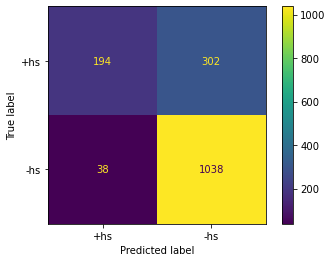

In [265]:
SVM(df_train['Tweets_S'].tolist(), 
   df_train['HS_Labels'].tolist(), 
   df_test['Tweets_S'].tolist(), 
   df_test['HS_Labels'].tolist())

<a id='LR'></a>
### Logistic Regression [&#8593;](#TOC)

In [276]:
def LR(train_X, train_y, test_X, test_y):
    
    #Define the logistic regression (LR) pipeline.
    text_clf = Pipeline([
         ('vect', CountVectorizer()),
         ('tfidf', TfidfTransformer()),
         ('clf', LogisticRegression(random_state=0))
    ])
        
    #Define the optional parameters to be tried with LR.
    params = {
         'vect__ngram_range': [(2,2),(2,3)],
         'clf__penalty': ('l1','l2','elasticnet'),
         'clf__C': (1,2),
         'tfidf__use_idf': (True, False)
    }
        
    #Try optional parameters with GridSearchCV
    gs_clf = GridSearchCV(text_clf, params, cv=5, n_jobs=-1)
    gs_clf.fit(train_X, train_y)
    preds = gs_clf.predict(test_X)
    
    #Get the best parameters.
    best_params = gs_clf.best_params_
    print()
    print("+----------------------------------------------------+")
    print(" Best parameters:")
    print("+----------------------------------------------------+")
    for key in best_params.keys():
        print(key + ': ' + str(best_params[key]))
    print()

    #Get the classification report.
    report = classification_report(test_y, preds, digits=6)
    print("+----------------------------------------------------+")
    print(" Classification report:")
    print("+----------------------------------------------------+")
    print(report)
    
    #Get the confusion matrix.
    cm = confusion_matrix(test_y, preds, labels=gs_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_clf.classes_)
    print("+----------------------------------------------------+")
    print(" Confusion Matrix:")
    print("+----------------------------------------------------+")
    disp.plot()

<a id='S-Baseline-LR'></a>
#### Baseline Performance for Sentiment Prediction [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 2
clf__penalty: l2
tfidf__use_idf: True
vect__ngram_range: (2, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

        +pos   0.710297  0.870588  0.782316       935
        -neg   0.715962  0.478807  0.573848       637

    accuracy                       0.711832      1572
   macro avg   0.713130  0.674698  0.678082      1572
weighted avg   0.712593  0.711832  0.697841      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


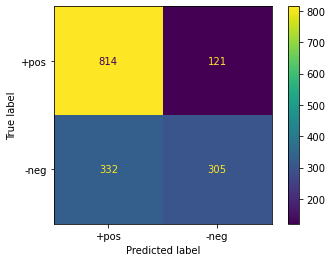

In [277]:
LR(df_train['Tweets'].tolist(), 
   df_train['S_Labels'].tolist(), 
   df_test['Tweets'].tolist(), 
   df_test['S_Labels'].tolist())

<a id='S+HS-LR'></a>
#### Performance with Additional Hate Speech Information [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 2
clf__penalty: l2
tfidf__use_idf: True
vect__ngram_range: (2, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

        +pos   0.724844  0.870588  0.791059       935
        -neg   0.730512  0.514914  0.604052       637

    accuracy                       0.726463      1572
   macro avg   0.727678  0.692751  0.697555      1572
weighted avg   0.727141  0.726463  0.715281      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


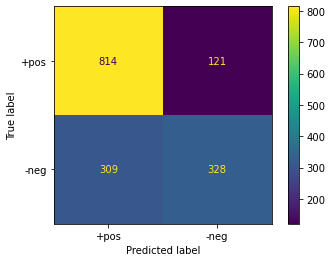

In [280]:
LR(df_train['Tweets_HS'].tolist(), 
   df_train['S_Labels'].tolist(), 
   df_test['Tweets_HS'].tolist(), 
   df_test['S_Labels'].tolist())

<a id='HS-Baseline-LR'></a>
#### Baseline Performance for Hate Speech Predictions [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 1
clf__penalty: l2
tfidf__use_idf: True
vect__ngram_range: (2, 3)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

         +hs   0.876471  0.300403  0.447447       496
         -hs   0.752496  0.980483  0.851493      1076

    accuracy                       0.765903      1572
   macro avg   0.814484  0.640443  0.649470      1572
weighted avg   0.791613  0.765903  0.724008      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


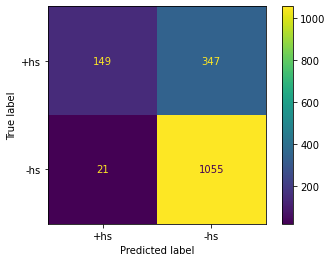

In [281]:
LR(df_train['Tweets'].tolist(), 
   df_train['HS_Labels'].tolist(), 
   df_test['Tweets'].tolist(), 
   df_test['HS_Labels'].tolist())

<a id='HS+S-LR'></a>
#### Performance with Additional Sentiment Information [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__C: 1
clf__penalty: l2
tfidf__use_idf: True
vect__ngram_range: (2, 3)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

         +hs   0.873626  0.320565  0.469027       496
         -hs   0.757554  0.978625  0.854015      1076

    accuracy                       0.770992      1572
   macro avg   0.815590  0.649595  0.661521      1572
weighted avg   0.794177  0.770992  0.732543      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


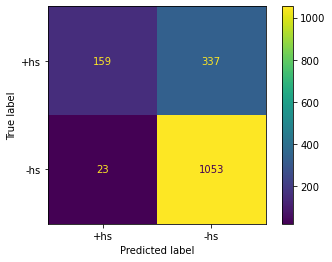

In [284]:
LR(df_train['Tweets_S'].tolist(), 
   df_train['HS_Labels'].tolist(), 
   df_test['Tweets_S'].tolist(), 
   df_test['HS_Labels'].tolist())

<a id='NB'></a>
### Naive Bayes [&#8593;](#TOC)

In [179]:
def NB(train_X, train_y, test_X, test_y):
    
    #Define the naive bayes (NB) pipeline.
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ])

    #Define the optional parameters to be tried with NB.
    params = {
        'vect__ngram_range':[(2,2),(1,2),(2,3)],
        'clf__alpha': (0.000001,1),
        'clf__fit_prior':(True, False),
        'tfidf__use_idf':(True, False)
    }

    #Try optional parameters with GridSearchCV
    gs_clf = GridSearchCV(text_clf, params, cv=5, n_jobs=-1)
    gs_clf.fit(train_X, train_y)
    preds = gs_clf.predict(test_X)

    #Get the best parameters.
    best_params = gs_clf.best_params_
    print()
    print("+----------------------------------------------------+")
    print(" Best parameters:")
    print("+----------------------------------------------------+")
    for key in best_params.keys():
        print(key + ': ' + str(best_params[key]))
    print()

    #Get the classification report.
    report = classification_report(test_y, preds, digits=6)
    print("+----------------------------------------------------+")
    print(" Classification report:")
    print("+----------------------------------------------------+")
    print(report)
    
    #Get the confusion matrix.
    cm = confusion_matrix(test_y, preds, labels=gs_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_clf.classes_)
    print("+----------------------------------------------------+")
    print(" Confusion Matrix:")
    print("+----------------------------------------------------+")
    disp.plot()

<a id='S-Baseline-NB'></a>
#### Baseline Performance for Sentiment Prediction [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__alpha: 1
clf__fit_prior: False
tfidf__use_idf: True
vect__ngram_range: (1, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

        +pos   0.756422  0.850267  0.800604       935
        -neg   0.731286  0.598116  0.658031       637

    accuracy                       0.748092      1572
   macro avg   0.743854  0.724192  0.729318      1572
weighted avg   0.746237  0.748092  0.742831      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


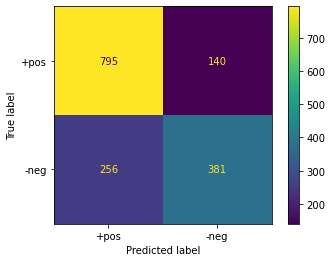

In [285]:
NB(df_train['Tweets'].tolist(), 
   df_train['S_Labels'].tolist(), 
   df_test['Tweets'].tolist(), 
   df_test['S_Labels'].tolist())

<a id='S+HS-NB'></a>
#### Performance with Additional Hate Speech Information [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__alpha: 1
clf__fit_prior: False
tfidf__use_idf: False
vect__ngram_range: (1, 2)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

        +pos   0.708571  0.928342  0.803704       935
        -neg   0.806916  0.439560  0.569106       637

    accuracy                       0.730280      1572
   macro avg   0.757744  0.683951  0.686405      1572
weighted avg   0.748422  0.730280  0.708641      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


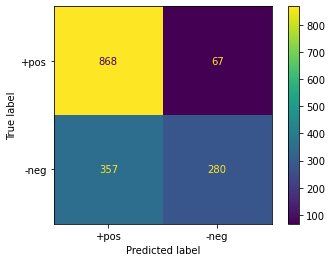

In [286]:
NB(df_train['Tweets_HS'].tolist(), 
   df_train['S_Labels'].tolist(), 
   df_test['Tweets_HS'].tolist(), 
   df_test['S_Labels'].tolist())

<a id='HS-Baseline-NB'></a>
#### Baseline Performance for Hate Speech Predictions [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__alpha: 1
clf__fit_prior: True
tfidf__use_idf: False
vect__ngram_range: (2, 3)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

         +hs   0.875000  0.296371  0.442771       496
         -hs   0.751425  0.980483  0.850806      1076

    accuracy                       0.764631      1572
   macro avg   0.813212  0.638427  0.646789      1572
weighted avg   0.790415  0.764631  0.722062      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


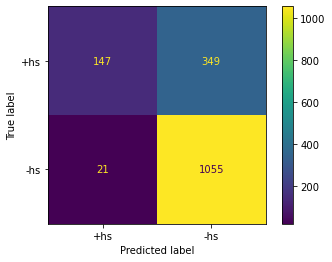

In [287]:
NB(df_train['Tweets'].tolist(), 
   df_train['HS_Labels'].tolist(), 
   df_test['Tweets'].tolist(), 
   df_test['HS_Labels'].tolist())

<a id='HS+S-NB'></a>
#### Performance with Additional Sentiment Information [&#8593;](#TOC)


+----------------------------------------------------+
 Best parameters:
+----------------------------------------------------+
clf__alpha: 1
clf__fit_prior: True
tfidf__use_idf: False
vect__ngram_range: (2, 3)

+----------------------------------------------------+
 Classification report:
+----------------------------------------------------+
              precision    recall  f1-score   support

         +hs   0.864198  0.282258  0.425532       496
         -hs   0.747518  0.979554  0.847949      1076

    accuracy                       0.759542      1572
   macro avg   0.805858  0.630906  0.636740      1572
weighted avg   0.784333  0.759542  0.714667      1572

+----------------------------------------------------+
 Confusion Matrix:
+----------------------------------------------------+


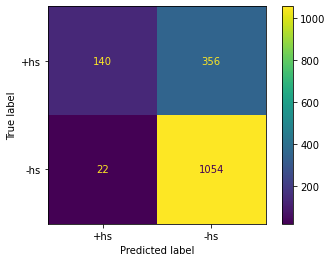

In [288]:
NB(df_train['Tweets_S'].tolist(), 
   df_train['HS_Labels'].tolist(), 
   df_test['Tweets_S'].tolist(), 
   df_test['HS_Labels'].tolist())

<a id='Conclusion'></a>
## Conclusion [&#8593;](#TOC)

The goal was to assess the extent to which information about hate speech correlates with sentiment and vice-versa. This was explored using three different classifiers (Support Vector, Logistic Regression, and Naive Bayes). First, a baseline for each classifier was obtained without the additional information (either hate speech or sentiment). Then, the additional information was used to compare. The results can be seen above, and the accuracy is summarized in Table 1 and Table 2. HS: hate speech information, S: sentiment information. <b>Bolded</b> values are the highest values obtained by the respective classifier.

<table style="width:75%">
    <tr>
        <th></th>
        <th>SV (base)</th>
        <th>SV (with HS)</th>
        <th>LR (base)</th>
        <th>LR (with HS)</th>
        <th>NB (base)</th>
        <th>NB (with HS)</th>
    </tr>
    <tr>
        <td><b>Accuracy</b></td>        
        <td>0.714377</td>
        <td><b>0.725827</b></td>        
        <td>0.711832</td>
        <td><b>0.726463</b></td>        
        <td><b>0.748092</b></td>
        <td>0.730280</td>
    </tr>
    <tr>
        <td><b>F1 (pos)</b></td>        
        <td>0.780655</td>
        <td><b>0.787580</b></td>        
        <td>0.782316</td>
        <td><b>0.791059</b></td>        
        <td>0.800604</td>
        <td><b>0.803704</b></td>
    </tr>
    <tr>
        <td><b>F1 (neg)</b></td>        
        <td>0.590702</td>
        <td><b>0.613453</b></td>        
        <td>0.573848</td>
        <td><b>0.604052</b></td>
        <td><b>0.658031</b></td>
        <td>0.569106</td>
    </tr>
</table>

<center><b><i>Table 1</i>: Sentiment Prediction Accuracy</b></center> 

<table style="width:75%">
    <tr>
        <th></th>
        <th>SV (base)</th>
        <th>SV (with S)</th>
        <th>LR (base)</th>
        <th>LR (with S)</th>
        <th>NB (base)</th>
        <th>NB (with S)</th>
    </tr>
    <tr>
        <td><b>Accuracy</b></td>        
        <td>0.782443</td>
        <td><b>0.783715</b></td>        
        <td>0.765903</td>
        <td><b>0.770992</b></td>        
        <td><b>0.764631</b></td>
        <td>0.759542 </td>
    </tr>
    <tr>
        <td><b>F1 (+hs)</b></td>        
        <td>0.526316</td>
        <td><b>0.532967</b></td>        
        <td>0.447447</td>
        <td><b>0.469027</b></td>        
        <td><b>0.442771</b></td>
        <td>0.425532</td>
    </tr>
    <tr>
        <td><b>F1 (-hs)</b></td>        
        <td>0.858794</td>
        <td><b>0.859272</b></td>        
        <td>0.851493</td>
        <td><b>0.854015</b></td>
        <td><b>0.850806</b></td>
        <td>0.847949</td>
    </tr>
</table>

<center><b><i>Table 2</i>: Hate Speech Detection Accuracy</b></center>

Including information about hate speech improved the overall accuracy of the sentiment predictions for each classifier *except* for Naive Bayes. The increase was not dramatic, however. Including information about sentiment had similar results for each classifier *except* for Naive Bayes. The reasons for this are worth further investigation. In general, the hypothesis is barely supported, yet worth pursuing further.

Unsupervised sentiment labeling is problematic for multiple reasons, e.g., sarcasm is difficult to detect (particularly with emoji), noise interferes with accurate labeling (as is the case with Twitter data the includes out-of-vocabulary tokens like hashtags, usernames, etc.). A supervised approach would be preferable, otherwise cleansing the data of Twitter-unique tokens might improve results. For that matter, the hate speech detection task has proven very difficult, so any improvement in that domain might also improve results. Also, instead of concatenating information, a better approach would probably be to divide the tasks into layers. Finally, it should also be noted that lexicon-based approaches to sentiment labeling misses the pragmatics of usage. This is still difficult for humans, but no nuance is provided in lexicon-based approaches.

<a id='References'></a>
## References [&#8593;](#TOC)

Bakharia, Aneesha (2016). Topic modeling with Scikit Learn. *Medium.com*. URL=https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730.

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A parsimonious rule-based model for sentiment analysis of social media text. *Eighth International Conference on Weblogs and Social Media (ICWSM-14)*. Github=https://github.com/cjhutto/vaderSentiment. Module used:
* [Sentiment Intensity Analyzer](https://www.nltk.org/_modules/nltk/sentiment/vader.html)

Mehrotra, Raj (2019). Topic modelling using LDA and LSA in Sklearn. *Kaggle.com*. URL=https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn.

Özcan, Said (2020). Preprocessor (Version 0.6.0) [Source Code]. URL=https://github.com/s/preprocessor.

Pedregosa et al. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research* 12, 2825-2830. URL=https://jmlr.csail.mit.edu/papers/volume12/pedregosa11a/pedregosa11a.pdf. Modules used:
* [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* [Confusion Matrix Display](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [TfIdfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

The Pandas Development Team (2021). Pandas (Version 1.2.4) [Source Code]. URL=https://pandas.pydata.org/.

Waseem, Zeerak and Dirk Hovy (2016). Hateful symbols or hateful people? Predictive features for hate speech detection on Twitter. *Proceedings of NAACL-HLT 2016*, 88-93. URL=https://www.aclweb.org/anthology/N16-2013.pdf. Github=https://github.com/zeerakw/hatespeech.